In [1]:
# 以下のtrainデータから特長量を作成し、学習モデルを生成させる。
# /mnt/c/Users/hayat/Desktop/keiba_analysis/data_for_train/train/2005_2022

In [2]:
!pip install lightGBM

In [3]:
import gc
gc.collect()

0

In [4]:
# /mnt/c/Users/hayat/Desktop/keiba_analysis/data_for_train/train/2005_2022
# のデータを取り込む

import warnings
from sklearn.svm import SVC, LinearSVC
from sklearn import multiclass
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
import scipy.stats
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import tqdm
# 指定したディレクトリ配下のcsvデータをreadする
is_denso = True
train_path = '/home/hayato/horse_inference/data_for_train/train/2005_2019/train_data_sorted_horse_standard_2005_2019.csv'
if is_denso:
    train_path = '/home/denso/horse_inference/data_for_train/train/2005_2019/train_data_sorted_horse_standard_2005_2019.csv'
train_data = pd.read_csv(train_path, encoding='utf-8')

print("train data length {}".format(len(train_data)))

train data length 741498


In [5]:
from pathlib import Path
import pandas as pd
import tqdm
def read_csv_data(train_path):
    # csvデータを読み込み、1行にまとめる
    p = Path(train_path)
    files = list(p.glob("inference*.csv"))
    df = pd.DataFrame()
    for i, file in tqdm.tqdm(enumerate(files)):
        race_csv_data = pd.read_csv(file, encoding='utf-8')
        # 各CSVファイルのデータを1行にまとめる
        race_csv_data = race_csv_data.sum(axis=0).to_frame().T
        
        # データフレームに追加
        df = pd.concat([df, race_csv_data], ignore_index=True)
    return df

inference_data = "/home/hayato/keiba_analysis/inference/2024070402/"
if is_denso:
    inference_data = "/home/denso/keiba_analysis/inference/2024070402/"
inference_data = read_csv_data(inference_data)
inference_data

0it [00:00, ?it/s]


""


In [6]:
train_data
# 不要な特長量であるUnnamed: 0、class_list_in_raceを削除する
train_data = train_data.drop(['Unnamed: 0','target_no1_umaban', 'class_list_in_race'], axis=1)
# 目的変数であるgoal_numberをグルーピングする。1であれば0、2と3は1にまとめる、4以上は2にまとめる
# これはlightGBMによる成約であり、0からクラス数-1の目的変数にラベリングしなければならない
train_data['goal_number'] = train_data['goal_number'].replace([1], 0)
train_data['goal_number'] = train_data['goal_number'].replace([2,3], 1)
train_data['goal_number'] = train_data['goal_number'].replace([4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], 2)

In [7]:
train_data.describe()

,date,number_of_horses,distance,umaban,horse_age,horse_sex,horse_weight,weight_change,handi,odds,goal_number
count,741498.000000,741498.000000,741498.000000,741498.000000,741498.000000,741498.000000,741498.000000,741498.000000,741498.000000,741498.000000,741498.000000
mean,2761.430461,14.783031,1642.615530,7.891516,3.656019,0.449531,469.330962,0.254822,55.058424,67.459365,1.720932
std,1569.579112,2.302275,432.645537,4.460383,1.349710,0.563194,36.993146,6.557119,1.782221,96.571090,0.583715
min,35.000000,4.000000,1000.000000,1.000000,2.000000,0.000000,-26.000000,-54.000000,47.000000,1.000000,0.000000
25%,1406.000000,14.000000,1200.000000,4.000000,3.000000,0.000000,450.000000,-4.000000,54.000000,8.700000,2.000000
50%,2759.000000,16.000000,1600.000000,8.000000,3.000000,0.000000,470.000000,0.000000,55.000000,25.900000,2.000000
75%,4117.000000,16.000000,1800.000000,11.000000,4.000000,1.000000,490.000000,4.000000,56.000000,84.200000,2.000000
max,5498.000000,18.000000,4260.000000,18.000000,13.000000,2.000000,640.000000,60.000000,66.000000,999.900000,2.000000


In [8]:
# train_dataの特長量のobject型は、LabelEncoderで数値に変換する
# object型の特長量を確認する
object_columns = train_data.select_dtypes(include='object').columns
object_columns
for column in object_columns:
    le = LabelEncoder()
    train_data[column] = le.fit_transform(train_data[column])


In [9]:
# inference_dataの特長量のobject型は、LabelEncoderで数値に変換する
# object型の特長量を確認する
object_columns = inference_data.select_dtypes(include='object').columns
object_columns
for column in object_columns:
    le = LabelEncoder()
    inference_data[column] = le.fit_transform(inference_data[column])

In [10]:
# columnの名前を確認し、:や 、"、'がある場合は_に置き換える
train_data.columns = train_data.columns.str.replace(":", "_")
train_data.columns = train_data.columns.str.replace(",", "_")
train_data.columns = train_data.columns.str.replace("'", "_")
train_data.columns = train_data.columns.str.replace('"', "_")
train_data.columns = train_data.columns.str.replace(" ", "_")


In [11]:
# train_data.info()

# # train_dataの中からgoal_numberとついたすべての名前の特長量を削除する
# train_data = train_data.drop(train_data.filter(like='goal_number').columns, axis=1)

# #inference_dataも同様にgoal_numberとついたすべての名前の特長量を削除する
# inference_data = inference_data.drop(inference_data.filter(like='goal_number').columns, axis=1)

In [12]:
# 学習データが大きすぎるので、train_dataの上から1000行を取得して学習データとする
train_data = train_data[30000:]
train_data

,date,race_name,place,number_of_horses,distance,condition,horse_name_,umaban,horse_age,horse_sex,horse_weight,weight_change,handi,jocky,odds,goal_number
30000,371,26,192,16,1700,0,20399,12,3,0,498,0,55.0,492,343.0,2
30001,371,26,192,16,1700,0,8378,13,3,0,486,8,53.0,202,371.4,2
30002,371,26,192,16,1700,0,47493,14,3,0,492,8,56.0,237,7.1,1
30003,371,26,192,16,1700,0,61185,15,3,1,448,-8,54.0,281,101.5,2
30004,371,26,192,16,1700,0,61588,16,5,0,484,8,54.0,598,21.4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741493,5381,24,126,16,2600,1,42111,12,3,1,468,2,52.0,422,17.5,2
741494,5381,24,126,16,2600,1,22318,13,4,0,486,12,57.0,496,7.7,2
741495,5381,24,126,16,2600,1,48057,14,4,0,484,18,57.0,440,4.4,0
741496,5381,24,126,16,2600,1,24450,15,4,0,504,-2,57.0,378,21.9,1


In [13]:
# train_dataを7:3でテストデータに分ける
from sklearn.model_selection import train_test_split
# テストデータと学習データ分割
train_total,test_total = train_test_split(train_data, test_size=0.3, random_state=42)

In [14]:
y = train_total['goal_number']
train_total.drop('goal_number', axis=1, inplace=True)

In [15]:
y_test_true = test_total['goal_number']
test_total.drop('goal_number', axis=1, inplace=True)

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(train_total, y, test_size=0.2, random_state=42)

train data length 398438
valid data length 99610
test data length 213450
train data length 398438
valid data length 99610
test data length 213450


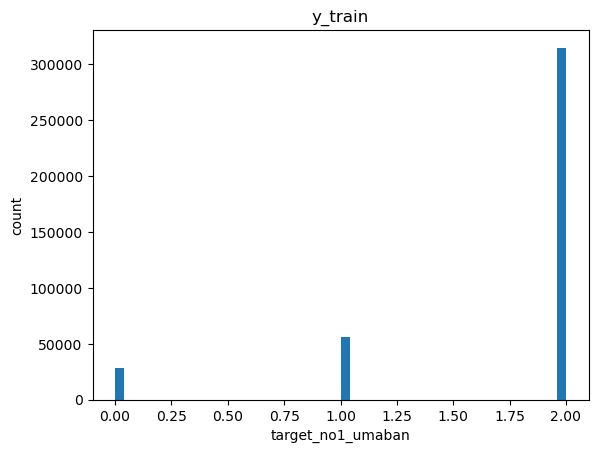

77076     0
731534    2
726246    2
333464    2
253761    2
         ..
203527    2
599382    1
565983    2
92360     2
110783    2
Name: goal_number, Length: 398438, dtype: int64


In [17]:
# 学習データ、検証データ、テストデータの割り振りが完了したので、それぞれのデータ数を表示する
print("train data length {}".format(len(X_train)))
print("valid data length {}".format(len(X_valid)))
print("test data length {}".format(len(test_total)))
# 回答データについても、同様にデータ数を表示する
print("train data length {}".format(len(y_train)))
print("valid data length {}".format(len(y_valid)))
print("test data length {}".format(len(y_test_true)))

# 回答データのヒストグラムを表示する
# 横軸をすべての番号で表示する
f, (ax) = plt.subplots()
ax.hist(y_train, bins=50)
ax.set_title('y_train')
ax.set_xlabel('target_no1_umaban')
ax.set_ylabel('count')

plt.show()

print(y_train)


In [18]:
import lightgbm as lgb
from sklearn.utils.class_weight import compute_sample_weight
dtrain = lgb.Dataset(X_train, label=y_train)  # 学習用
dvalid = lgb.Dataset(X_valid, label=y_valid)  # early_stopping用
# precisionの向上には重みづけが有効
# dtrain = lgb.Dataset(X_train, label=y_train, weight=compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
# dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)
# https://qiita.com/Dixhom/items/fd78f461d038798a7e2e
# fobj=fobjというハイパラもある？
print(compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
print(np.ones(len(X_valid)).astype('float32'))

[4.7707415  0.42167705 0.42167705 ... 0.42167705 0.42167705 0.42167705]
[1. 1. 1. ... 1. 1. 1.]


In [19]:
# feature_names = dtrain.feature_name
# clean_feature_names = [name.replace(' ', '_').replace(':', '_').replace('"', '_').replace("'", '_') for name in feature_names]
# # データセットに新しい特徴量名を設定
# dtrain.feature_name = clean_feature_names
# dvalid.feature_name = clean_feature_names

In [20]:
learning_rate = 0.01
num_leaves = 15
max_depth = 12
min_data_in_leaf = 10
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    # 'metric': 'rmse',
    'metric': 'multi_logloss',
    # 'metric': 'auc', # AUCでもいい
    'num_class': 3, # クラスの数
    
    # "seed":[31],
    # 'random_state': [42],
    # 'lambda_l2':5, # L2正則化をデフォルト1から5にして過学習の抑制を試みる。
    # #'lambda_l1':100, # L1正則化をデフォルト1から5にして過学習の抑制を試みる。
    # 'verbose' : [-1],
    "num_iterations":10000, # early stopping で止まるため大きめに設定しておけばよい
    
    # 以下のパラメータを調整対象とする
    "learning_rate": learning_rate, #学習率
    "num_leaves":num_leaves,
    "max_depth":max_depth,
    "min_data_in_leaf":min_data_in_leaf,
    # "bagging_fraction":[0.8],
    # "bagging_freq":[1],
}

In [ ]:
#学習
# 以下を参考にearly stoppingを10で設定
# https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4
# ステップごとの処理結果の保存コールバックで実施するよう仕様変更更
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.record_evaluation.html

verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
evaluation_results = {} 
import time
starttime = time.time()
# best_params = gcv.best_params_
best_params = params

gbm = lgb.train(best_params,
                dtrain,
                #categorical_feature=categorical_features,
                valid_sets=[dtrain,dvalid],
                valid_names=['train', 'valid'],     
                num_boost_round = 10000,
                # feval=acquire_custom_metircs, 
                callbacks=[lgb.early_stopping(stopping_rounds=100, 
                                verbose=True), # early_stopping用コールバック関数
                           lgb.log_evaluation(verbose_eval),
                           lgb.record_evaluation(evaluation_results)] # コマンドライン出力用コールバック関数
                )

/home/denso/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 398438, number of used features: 15
[LightGBM] [Info] Start training from score -2.661114
[LightGBM] [Info] Start training from score -1.968721
[LightGBM] [Info] Start training from score -0.235097
Training until validation scores don't improve for 100 rounds


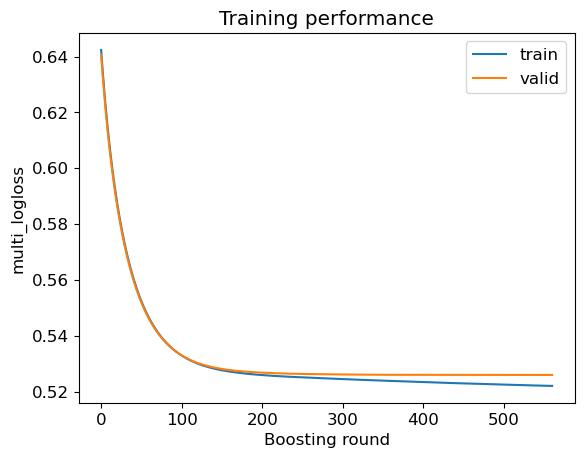

In [ ]:
# 学習過程の可視化
plt.rcParams["font.size"] = 12
plt.plot(evaluation_results['train']['multi_logloss'], label='train')
plt.plot(evaluation_results['valid']['multi_logloss'], label='valid')
plt.ylabel('multi_logloss')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()
plt.show()

In [ ]:
# 検証データを推論
y_pred_train = gbm.predict(X_valid)
y_pred_train = pd.DataFrame(y_pred_train)
print(y_pred_train.head())
print(y_pred_train[0])

             0         1         2         3             4             5   \
0  5.603506e-16  0.009300  0.047808  0.942892  5.603506e-16  5.603506e-16   
1  1.174069e-15  0.081755  0.245018  0.673226  1.174069e-15  1.174069e-15   
2  1.377106e-15  0.234437  0.344139  0.421425  1.377106e-15  1.377106e-15   
3  9.664052e-16  0.047471  0.140419  0.812109  9.664052e-16  9.664052e-16   
4  1.087226e-15  0.068140  0.221205  0.710655  1.087226e-15  1.087226e-15   

             6             7             8             9             10  \
0  5.603506e-16  5.603506e-16  5.603506e-16  5.603506e-16  5.603506e-16   
1  1.174069e-15  1.174069e-15  1.174069e-15  1.174069e-15  1.174069e-15   
2  1.377106e-15  1.377106e-15  1.377106e-15  1.377106e-15  1.377106e-15   
3  9.664052e-16  9.664052e-16  9.664052e-16  9.664052e-16  9.664052e-16   
4  1.087226e-15  1.087226e-15  1.087226e-15  1.087226e-15  1.087226e-15   

             11            12            13            14            15  \
0  5.603506

In [ ]:
y_pred_int = y_pred_train.idxmax(axis=1)
# y_pred_int = np.argmax(y_pred_train.values, axis=1)
# y_pred_int = y_pred_train.astype(int)
y_pred_int

0        3
1        3
2        3
3        3
4        3
        ..
99605    3
99606    3
99607    3
99608    3
99609    3
Length: 99610, dtype: int64

In [25]:
# yvalidのラベルの配列をy_pred_trainから取得して正解のラベルの予測確率値を取得
y_pred_correct = []
for i, y_val in enumerate(y_valid):
    # 行指定で各確率値を取得
    y_pred = y_pred_train.iloc[i]
    y_probability = y_pred[y_val]
    y_pred_correct.append(y_probability)

# ラベル無視して最大確率のみを抽出した配列。
y_pred_correct

# ラベルごとの確率値を取得
# 0~10のラベルごとの確率値を取得
y_pred_categorical = [[] for _ in range(19)]
for i, y_val in enumerate(y_valid):
    # 行指定で各確率値を取得
    y_pred = y_pred_train.iloc[i]
    y_probability = y_pred[y_val]
    y_pred_categorical[y_val].append(y_probability)

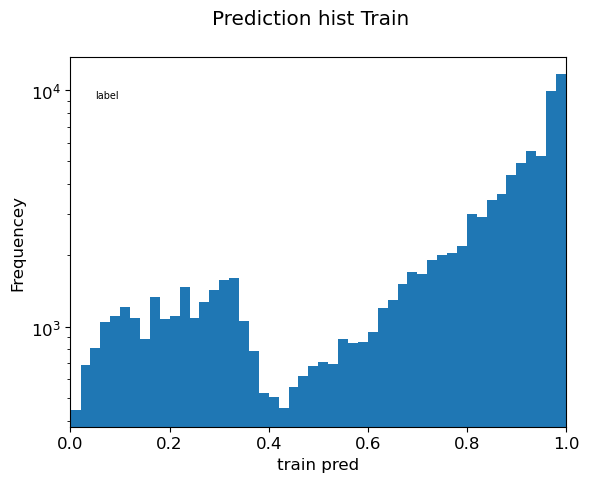

In [ ]:
# 正解ラベルの確率値のヒストグラム作成
f, (ax) = plt.subplots()
f.suptitle('Prediction hist Train')

bins = 50

ax.hist(y_pred_correct, bins = bins)

plt.xlabel('train pred')
plt.ylabel('Frequencey')
plt.xlim((0, 1))
plt.yscale('log')
plt.text(0.05, 0.89, 'label',transform = ax.transAxes, fontsize = 7)
plt.show();

# 確率が低い（つまり他のジャンルと分類される）ものが多い。理想は左画はほぼなくて、右に寄ったグラフが作成できること。

In [27]:
# for i, y_pred_category in enumerate(y_pred_categorical):
#     f, (ax) = plt.subplots()
#     f.suptitle('Prediction hist Train')

#     bins = 50

#     ax.hist(y_pred_category, bins = bins)

#     plt.xlabel('train pred')
#     plt.ylabel('Frequencey')
#     plt.xlim((0, 1))
#     plt.yscale('log')
#     plt.text(0.05, 0.9, 'labele is :{}'.format(i),transform = ax.transAxes, fontsize = 14)
#     plt.show();

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

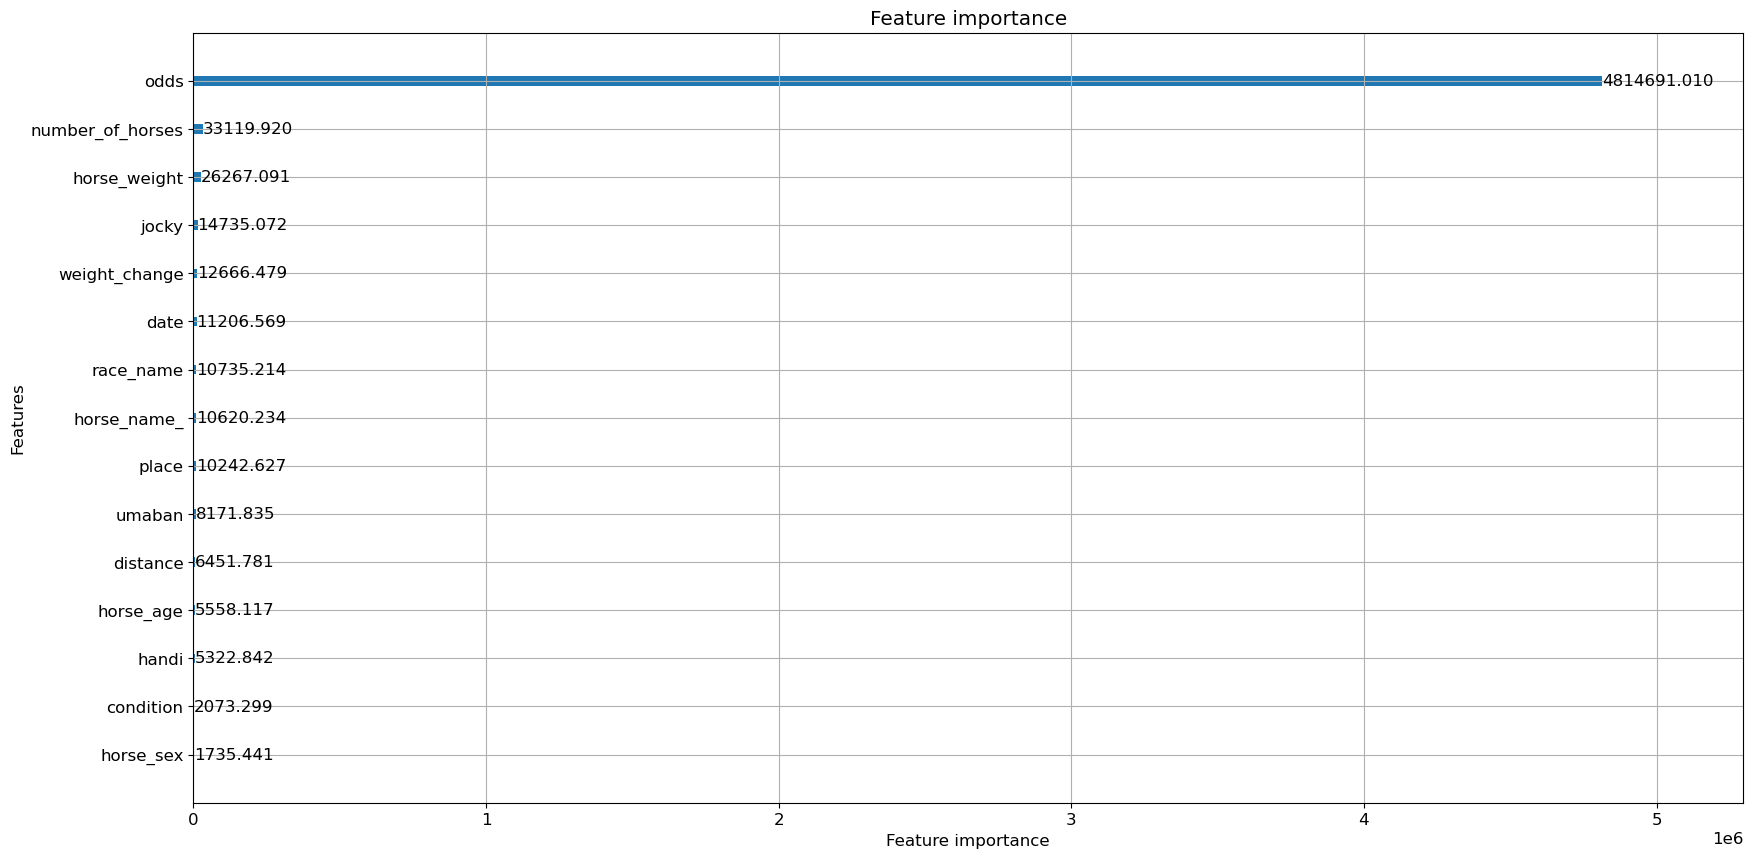

In [ ]:
# 4. feature importanceが確認できる
# 特徴点（特徴量）の寄与率を明示化する。特徴点抽出
# 学習後、以下のURLを参考に寄与率を算出させてみる。
# https://qiita.com/ku_a_i/items/74241c84cda8c7327277
lgb.plot_importance(gbm, figsize=(20,10),importance_type='gain')

f1_score=0.7968979018170866


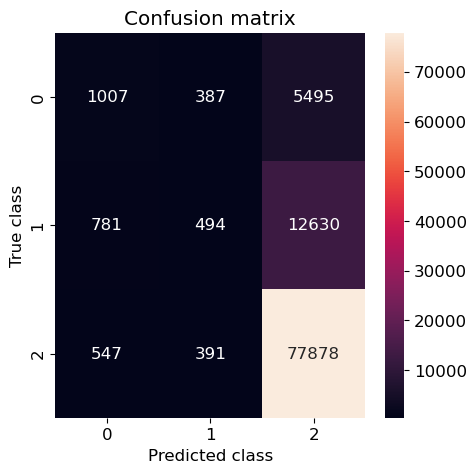

In [ ]:
import os
import datetime
from sklearn import metrics
Dicision_threshould = 0.5

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "LightGBM"+ "_" + str(Dicision_threshould)+ '.png'


if not os.path.isdir(path):
   os.mkdir(path)


# スコア(RMSE)算出
# y_pred_int = np.where(y_pred_train > Dicision_threshould, 1, 0)
y_pred_int = y_pred_train.idxmax(axis=1)

f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")
print(f'f1_score={f1_score}')

label = ["一位","二位か三位","四位以降"]

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int, xlabel=label, ylabel=label)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()

f1_score=0.7968979018170866


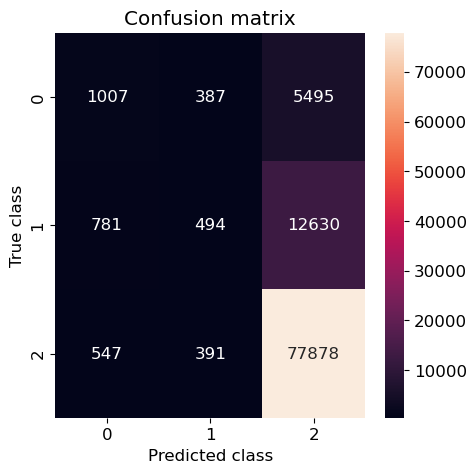

In [ ]:
import os
import datetime
from sklearn import metrics

Dicision_threshould = 0.7

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "Ansamble"+ "_" + str(Dicision_threshould)+ '.png'

# y_pred_train_ansamble = (y_pred_train_rf + y_pred_train) / 2.0


# スコア(RMSE)算出

# y_pred_train_ansamble = y_pred_int * 0.8 + y_pred_train_rf * 0.2
# y_pred_int = y_pred_train_ansamble.idmax(axis=1)


f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")
print(f'f1_score={f1_score}')

plt.rcParams["font.size"] = 12

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int,xlabel=label, ylabel=label)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()


inference test data and compare with test correct data
              precision    recall  f1-score   support

           1       0.44      0.14      0.21     14865
           2       0.39      0.04      0.07     29646
           3       0.81      0.99      0.89    168939

    accuracy                           0.80    213450
   macro avg       0.55      0.39      0.39    213450
weighted avg       0.73      0.80      0.73    213450



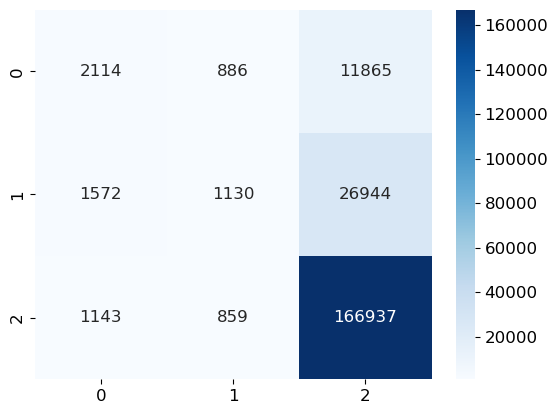

In [31]:
########### inference test data and compare with test correct data ###########
print("inference test data and compare with test correct data")
# ワンホットベクトル化しているのでテストのほうではカラムがないやつもあり数がずれるのでこの引数が必要。
y_pred = gbm.predict(test_total)
y_pred = pd.DataFrame(y_pred)
y_pred_submit = y_pred.idxmax(axis=1)

# テストデータの推論結果と、正解データを比較する
from sklearn.metrics import classification_report
print(classification_report(y_test_true, y_pred_submit))
# confusion matrixを表示する
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_true, y_pred_submit,xlabel=label, ylabel=label)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.show()

print("inference test data")
print(y_test_true)

print("answer test data")
print(y_pred_submit)

In [ ]:
############ real inference ############
print("real inference")
# ワンホットベクトル化しているのでテストのほうではカラムがないやつもあり数がずれるのでこの引数が必要。
y_pred = gbm.predict(inference_data)
y_pred = pd.DataFrame(y_pred)
y_pred_submit = y_pred.idxmax(axis=1)
print(y_pred.head())
print(y_pred[0])
print(y_pred_submit)


real inference


ValueError: Input data must be 2 dimensional and non empty.